# Model Explicit Likelihood Inference
Infer from a cosmological model via MCMC samplers. 

In [6]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.50' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jr
from jax import jit, vmap, grad, debug, lax, flatten_util
from jax.tree_util import tree_map

import numpyro
from numpyro.handlers import seed, condition, trace
from functools import partial
from getdist import plots

%matplotlib inline
%load_ext autoreload 
%autoreload 2

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
# mlflow.set_experiment("ELI")
from montecosmo.utils import pickle_dump, pickle_load, get_vlim, theme_switch, sample_and_save, load_runs
save_dir = os.path.expanduser("~/scratch/pickles/")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Inference

### Import

In [7]:
from montecosmo.models import pmrsd_model, prior_model, get_logp_fn, get_score_fn, get_simulator, get_pk_fn, get_param_fn, get_noise_fn
from montecosmo.models import print_config, condition_on_config_mean, default_config as config
# Build and render model
config.update(a_lpt=0.5, mesh_size=64*np.ones(3, dtype=int))
model = partial(pmrsd_model, **config)
print_config(model)

# Get fiducial parameters
fiduc_model = partial(model, trace_reparam=True) # lik_config={'obs_std':0.1}
fiduc_params = get_simulator(condition_on_config_mean(fiduc_model))(rng_seed=0)
# pickle_dump(fiduc_params, save_dir+"fiduc_params.p")
# fiduc_params = pickle_load(save_dir+"fiduc_params.p")

# Condition model on observables
obs_names = ['obs_mesh']
# obs_names = ['obs_mesh','Omega_c_','sigma8_','b1_','b2_','bs_','bnl_']
obs_params = {name: fiduc_params[name] for name in obs_names}
obs_model = condition(model, obs_params)

# Get and vectorize relevant functionals
logp_fn = get_logp_fn(obs_model)
score_fn = get_score_fn(obs_model)
pk_fn = get_pk_fn(**config)
param_fn = get_param_fn(**config)
pk_vfn = jit(vmap(pk_fn))
param_vfn = jit(vmap(param_fn))

# CONFIG
{'mesh_size': array([64, 64, 64]), 'box_size': array([640., 640., 640.]), 'a_lpt': 0.5, 'a_obs': 0.5, 'galaxy_density': 0.001, 'trace_reparam': False, 'trace_meshes': False, 'prior_config': {'Omega_c': ['{\\Omega}_c', 0.25, 0.1], 'sigma8': ['{\\sigma}_8', 0.831, 0.14], 'b1': ['{b}_1', 1.0, 0.5], 'b2': ['{b}_2', 0.0, 0.5], 'bs2': ['{b}_{s^2}', 0.0, 0.5], 'bn2': ['{b}_{\\nabla^2}', 0.0, 0.5]}, 'lik_config': {'obs_std': 1}}

# INFOS
cell_size:        [10.0, 10.0, 10.0] Mpc/h
delta_k:          0.00982 h/Mpc
k_nyquist:        0.31416 h/Mpc
mean_gxy_density: 1.000 gxy/cell



/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


### Run

In [78]:
# num_samples, max_tree_depth, n_runs = 4429, 3, 20
# num_samples, max_tree_depth, n_runs = 2000, 5, 10
# num_samples, max_tree_depth, n_runs = 243, 8, 10 
# num_samples, max_tree_depth, n_runs, num_chains = 256, 5, 1, 2
num_samples, max_tree_depth, n_runs, num_chains = 256, 10, 4, 8

# num_samples, max_tree_depth, n_runs = 30, 11, 10
# num_samples, max_tree_depth, n_runs = 15, 12, 10

nuts_kernel = numpyro.infer.NUTS(
    model=obs_model,
    init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=True,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # XXX: dense matrix for cosmo params joint, diagonal for the rest
    # step_size=0.01, 
    adapt_step_size=True,
    max_tree_depth=max_tree_depth,)

hmc_kernel = numpyro.infer.HMC(
    model=obs_model,
    init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
    # adapt_mass_matrix=False,
    step_size=1e-40, 
    # adapt_step_size=False,
    num_steps=1,)

# # Propose MALA step size based on Chen+2019 http://arxiv.org/abs/1801.02309
# L_smoothness, m_strong_convex = 1, 1 # log density regularity properties
# condition_number = L_smoothness / m_strong_convex
# print(f"MALA step size proposal={1 / (L_smoothness * (config['mesh_size'].prod() * condition_number)**0.5):e}")

# from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA
# mala_kernel = MALA(model=obs_model,
#                     init_strategy=numpyro.infer.init_to_value(values=fiduc_params),
#                     step_size=0.001,)

mcmc = numpyro.infer.MCMC(
    sampler=nuts_kernel,
    num_warmup=num_samples,
    # num_warmup=0,
    num_samples=num_samples, # for each run
    num_chains=num_chains,
    chain_method="vectorized",
    progress_bar=True,)

# Variables to save
extra_fields = ['num_steps'] # e.g. 'num_steps'
save_path = save_dir + f"NUTS_ns{num_samples:d}_standard1."

# last_state = pickle_load(save_dir+"NUTS_ns60_mtd10_laststate16.p")
# mcmc.post_warmup_state = last_state

In [5]:
# mlflow.end_run()
# mlflow.start_run(run_name="NUTS, standard")
# mlflow.log_params(config)
# mlflow.log_params({'n_runs':n_runs, 'num_samples':num_samples, 'max_tree_depth':max_tree_depth, 'num_chains':num_chains})

In [5]:
# mlflow.log_metric('halt',0) # 31.46s/it 4chains, 37.59s/it 8chains
mcmc_runned = sample_and_save(mcmc, n_runs, save_path, extra_fields=extra_fields)
# mlflow.log_metric('halt',1)

run 0/4 (warmup)
sample: 100%|██████████| 256/256 [2:40:43<00:00, 37.67s/it]


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/256 [00:00<?, ?it/s]/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
warmup: 100%|██████████| 256/256 [2:38:08<00:00, 37.06s/it]  


run 1/4


sample: 100%|██████████| 256/256 [2:38:38<00:00, 37.18s/it]  


run 2/4


sample:  12%|█▎        | 32/256 [20:04<2:20:38, 37.67s/it]

run 3/4


sample:  61%|██████▏   | 157/256 [1:37:16<1:01:20, 37.17s/it]

## Analysis

In [6]:
# temp = pickle_load(save_dir+'NUTS_mtd10_2.p')
# print(temp.keys())
# temp['bs2_'] = temp['bs_']
# temp['bn2_'] = temp['bnl_']
# temp.pop('bs_')
# temp.pop('bnl_')
# print(temp.keys())
# # pickle_dump(temp, save_dir+'NUTS_mtd10_2.p')

In [79]:
start_run, end_run = 1,1
# Load saved samples
var_names = [name+'_' for name in config['prior_config']] + ['num_steps']
# var_names = None

post_samples_ = load_runs(save_path, start_run, end_run, var_names, conc_axis=[1,0], verbose=True)
# mlflow.log_params({'n_samples':n_samples, 'n_evals':n_evals})

# post_samples = [param_vfn(**s) for s in post_samples_]
post_samples = param_vfn(**post_samples_)

loading: NUTS_ns256_standard1.
total n_samples: (2048,), total n_evals: 2095104


### Chain

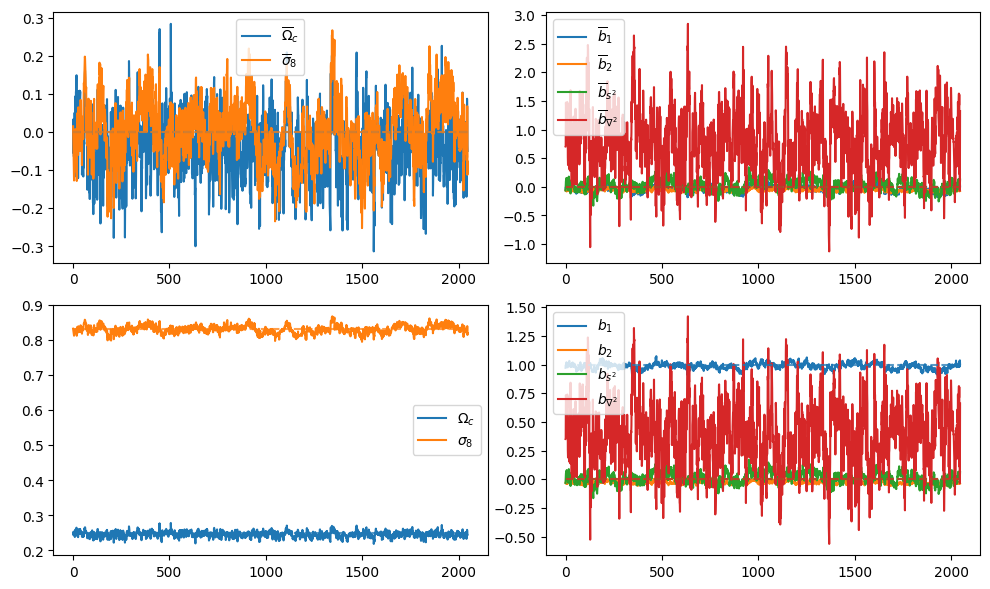

In [80]:
def plot_chain(samples:dict, prior_config:dict, fiduc:dict, **config):
    labels = []
    for name in samples:
        if name.endswith('_'): # convention for a latent value 
            lab = "\overline"+prior_config[name[:-1]][0]
        else:
            lab = prior_config[name][0]
        labels.append('$'+lab+'$')

    samples_arr = np.array(list((samples.values()))).T

    plt.plot(samples_arr, label=labels)
    plt.hlines([fiduc[name] for name in samples], 
            xmin=0, xmax=len(samples_arr), 
            ls="--", alpha=0.75,
            color=[f"C{i}" for i in range(len(samples))],)
slice_toplot = np.concatenate([range(i,i+10) for i in [0,5*60-5, 6*60-5]])

plot_fn = partial(plot_chain, fiduc=fiduc_params, **config)
plt.figure(figsize=(10,6))
plt.subplot(221)
plot_fn({name:post_samples_[name] for name in ['Omega_c_','sigma8_']})
plt.legend(), 
plt.subplot(222)
plot_fn({name:post_samples_[name] for name in ['b1_','b2_','bs2_','bn2_']})
plt.legend(), 
plt.subplot(223)
plot_fn({name:post_samples[name] for name in ['Omega_c','sigma8']})
plt.legend(), 
plt.subplot(224)
plot_fn({name:post_samples[name] for name in ['b1', 'b2','bs2','bn2']})
plt.legend(), 
plt.tight_layout()
# mlflow.log_figure(plt.gcf(), f"NUTS_chain.svg")
plt.show();

### Contours

In [ ]:
paths = ["NUTS_ns4429_mtd3","NUTS_ns243_mtd8","NUTS_ns60_mtd10","NUTS_ns15_mtd12"]
legend_labels = ["NUTS, mtd=3", "NUTS, mtd=8","NUTS, mtd=10","NUTS, mtd=12"]
start_run, end_run = [1,1,1,1], [10,5,5,5]

load_paths = np.array([os.path.join(save_dir, path) for path in paths])
var_names = [name+'_' for name in config['prior_config']]

post_samples_ = load_runs(load_paths, start_run, end_run, var_names, verbose=True)
post_samples = [param_fn(**s) for s in post_samples_]

loading: NUTS_ns4429_mtd3
total run length: 44290
loading: NUTS_ns243_mtd8
total run length: 1215
loading: NUTS_ns60_mtd10
total run length: 300
loading: NUTS_ns15_mtd12
total run length: 75


In [77]:
# post_samples2 = {name[:-1]: post_samples_[name] for name in post_samples_}
# post_samples2.pop('num_step');

In [70]:
from numpyro.diagnostics import print_summary
print_summary(post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.25      0.01      0.25      0.23      0.26    694.43      1.00
        b1      0.99      0.03      0.99      0.95      1.04    118.98      1.00
        b2     -0.03      0.01     -0.03     -0.05     -0.01    219.26      1.00
       bn2      0.36      0.29      0.36     -0.09      0.84    441.82      1.00
       bs2      0.02      0.05      0.02     -0.06      0.10    187.46      1.00
    sigma8      0.83      0.01      0.83      0.81      0.85    173.14      1.00



Removed no burn in
# NUTS, mtd=10
using 2048 rows, 6 parameters; mean weight 1.0, tot weight 2048.0
Equiv number of single samples (sum w)/max(w): 2048
Effective number of weighted samples (sum w)^2/sum(w^2): 2048


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_c      0.25      0.01      0.25      0.23      0.26    502.43      1.00
        b1      0.99      0.03      0.99      0.94      1.04     43.66      1.00
        b2     -0.03      0.01     -0.03     -0.05     -0.01     60.67      1.00
       bn2      0.40      0.29      0.41     -0.08      0.87    238.03      1.00
       bs2      0.01      0.05      0.01     -0.08      0.09     74.66      1.01
    sigma8      0.83      0.01      0.83      0.81      0.85     51.00      1.00

Removed no burn in
# NUTS, mtd=10
using 2048 rows, 6 parameters; mean weight 1.0, tot weight 2048.0
Equiv number of single samples (sum w)/max(w): 2048
Effective number of weighted samples (sum w)^2/sum(w^2): 2048




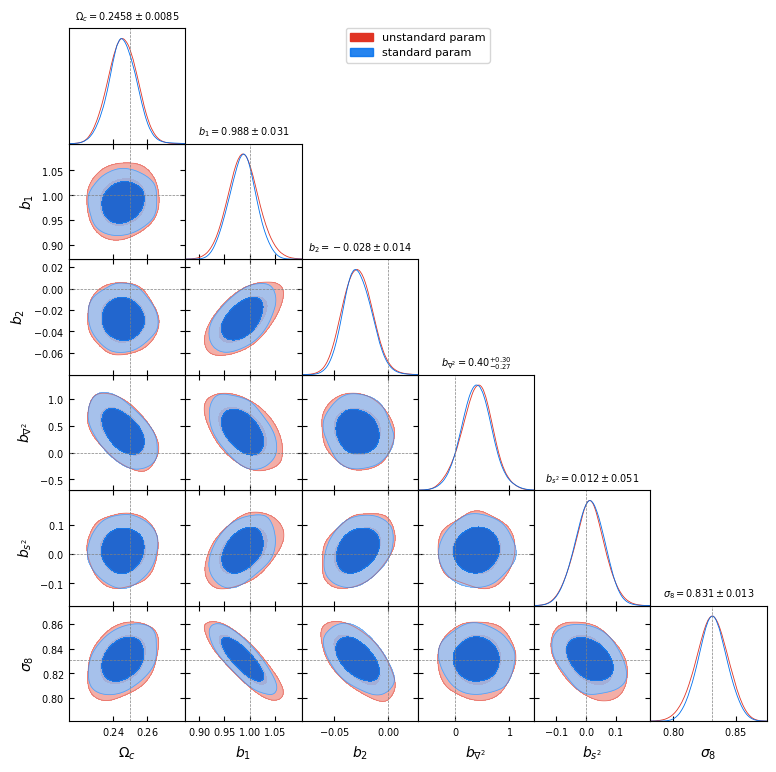

In [83]:
from montecosmo.utils import get_gdsamples, get_gdprior

gdsamples = get_gdsamples(post_samples, label="NUTS, mtd=10", verbose=True, **config)
gd1 = gdsamples.copy(label="standard param", settings={'smooth_scale_2D':1,'smooth_scale_1D':1,})

# gdsamples.append(get_gdprior(post_samples, verbose=True, **config))
g = plots.get_subplot_plotter(width_inch=9)
# g.settings.solid_colors='tab10_r's
g.triangle_plot(roots=[gd2, gd1] , 
                title_limit=1, 
                filled=True, 
                # param_limits={n:[m-2*s,m+2*s] for n,m,s in zip(names, mean, std)},
                markers=fiduc_params,
                )
# mlflow.log_figure(plt.gcf(), f"NUTS_contour_mtd3-8-10-12.svg", save_kwargs={'bbox_inches':'tight'}) # NOTE: tight bbox better
# plt.savefig('NUTS_mtd10_8192_unstandard_short.svg', bbox_inches='tight')
plt.show();

Removed no burn in
Removed no burn in
Removed no burn in


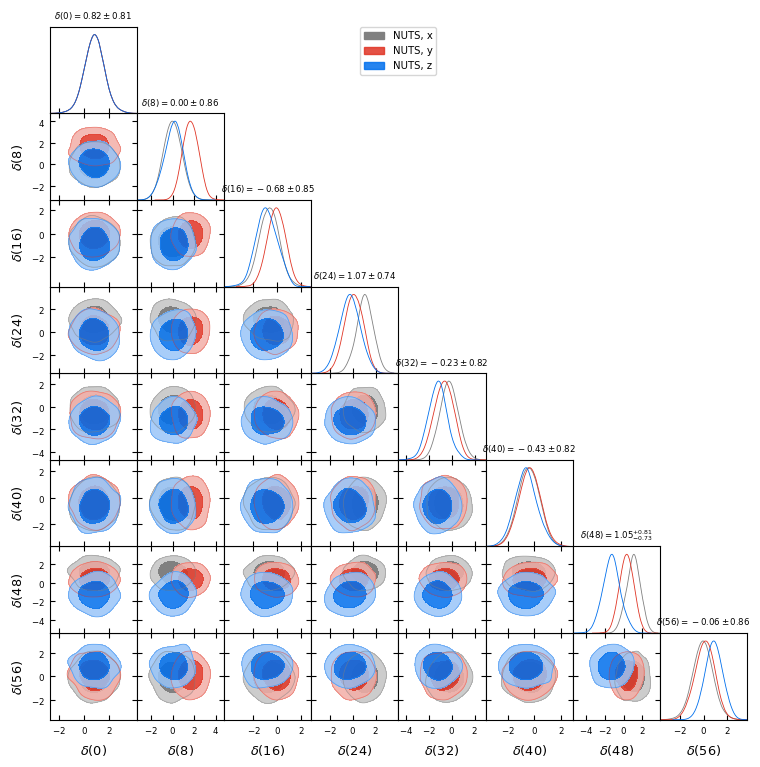

In [129]:
from getdist import MCSamples

def get_gdsamples_mesh(samples:dict, fiduc:dict, n:int, stop:int=None, axis:int=0, label:str=None):
    mesh_samples = samples['init_mesh']
    mesh_fiduc = fiduc['init_mesh']

    subsamples = {}
    subfiduc = {}
    labels = []
    slices0 = len(mesh_fiduc.shape)*[slice(0,1)]
    name0 = len(mesh_fiduc.shape) * ["0"]
    if stop is None:
        stop = mesh_fiduc.shape[axis]
    for i in np.linspace(0, stop, n, endpoint=False, dtype=int):
        slices, name = slices0.copy(), name0.copy()
        slices[axis] = slice(i,i+1)
        # name[axis] = str(i)
        # name = "delta("+",".join(name)+")"
        # lab = "\\"+name
        name = f"delta({i})"
        lab = "\\"+name

        subsamples[name] = mesh_samples[:,*slices].squeeze()
        subfiduc[name] = mesh_fiduc[*slices].squeeze()
        labels.append(lab)
 
    gdsamples = MCSamples(samples=list(subsamples.values()), names=list(subsamples.keys()), labels=labels, label=label)
    return gdsamples, subfiduc

ntoplot = 8
stop = None
gdsamplesX, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=0, label="NUTS, x")
gdsamplesY, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=1, label="NUTS, y")
gdsamplesZ, subfiduc = get_gdsamples_mesh(post_samples, fiduc_params, ntoplot, stop, axis=2, label="NUTS, z")

g.triangle_plot(roots=[gdsamplesX, gdsamplesY, gdsamplesZ] , 
                title_limit=1, 
                filled=True, 
                # markers=subfiduc,
                )
plt.savefig('NUTS_mtd10_1560_meshtriangle.svg', dpi=200, bbox_inches='tight')
plt.show();

### Spectrum distribution

In [175]:
from jaxpm.painting import cic_paint, cic_read, compensate_cic
pk_fiduc = pk_fn(fiduc_params['init_mesh'])
pk_post = vmap(pk_fn)(post_samples['init_mesh'])
qs = jnp.array([0.0015, 0.0250, 0.1600, 0.5, 0.840, 0.9750, 0.9985])
pk_0015, pk_0250, pk_1600, pk_5000, pk_8400, pk_9750, pk_9985 = jnp.quantile(pk_post, q=qs, axis=0)

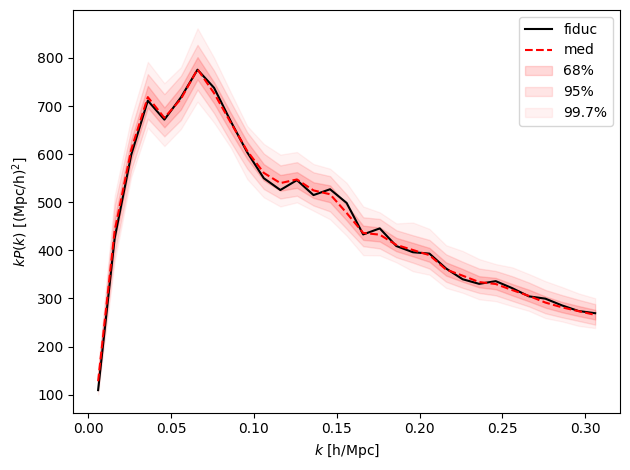

In [178]:
plot_fn = lambda pk, *args, **kwargs: plt.plot(pk[0], pk[0]*pk[1], *args, **kwargs)
plotfill_fn = lambda pklow, pkup, *args, **kwargs: plt.fill_between(pklow[0], pklow[0]*pklow[1], pklow[0]*pkup[1], *args, **kwargs)

plot_fn(pk_fiduc, 'k', label='fiduc')
plot_fn(pk_5000, 'r--', label='med')
plotfill_fn(pk_1600, pk_8400, alpha=0.15, color='red', label='68%')
plotfill_fn(pk_0250, pk_9750, alpha=0.10, color='red', label='95%')
plotfill_fn(pk_0015, pk_9985, alpha=0.05, color='red', label='99.7%')
plt.xlabel("$k$ [h/Mpc]"), plt.ylabel(f"$k P(k)$ [(Mpc/h)$^2$]")
plt.legend()
plt.tight_layout()
plt.savefig('post_pk.svg', dpi=200, bbox_inches='tight')
plt.show()

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


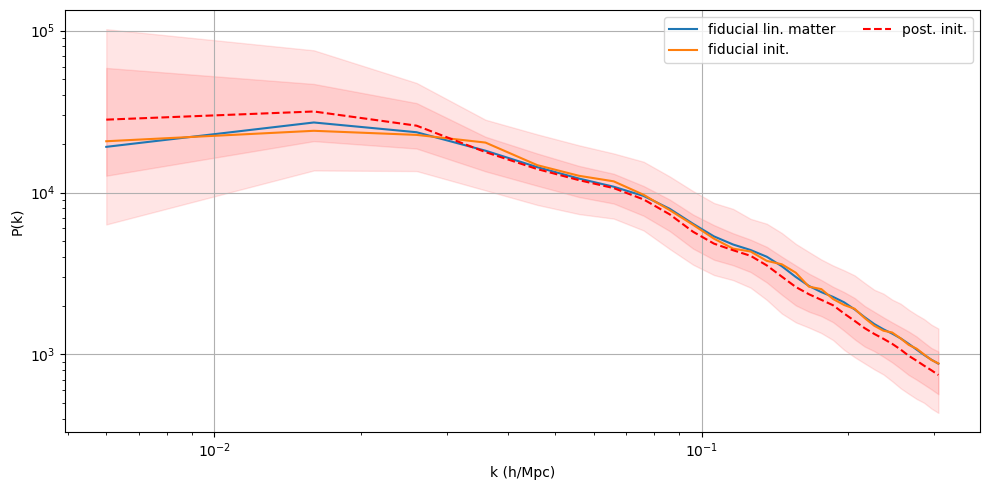

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"fiducial lin. matter")
plt.loglog(pk_init[0], pk_init[1], label=f"fiducial init.")
plt.loglog(pk_init[0], pk_500, color='red', ls='--', label=f"post. init.")
plt.fill_between(pk_init[0], pk_159, pk_841, alpha=0.1, color='red')
plt.fill_between(pk_init[0], pk_023, pk_977, alpha=0.1, color='red')
plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.grid(), plt.tight_layout()
plt.savefig(save_path+"_Pkdist");

### Mass matrix

In [132]:
# Load mass matrix
import pickle
with open(save_path+f"_laststate16.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(last_state.adapt_state.step_size, inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

0.0036300123 {('Omega_c_', 'b1_', 'b2_', 'bnl_', 'bs_', 'init_mesh_', 'sigma8_'): Array([6.1043068e-03, 1.6954450e-03, 7.9886860e-04, ..., 8.5615098e-01,
       6.2965083e-01, 3.9922595e-03], dtype=float32)}


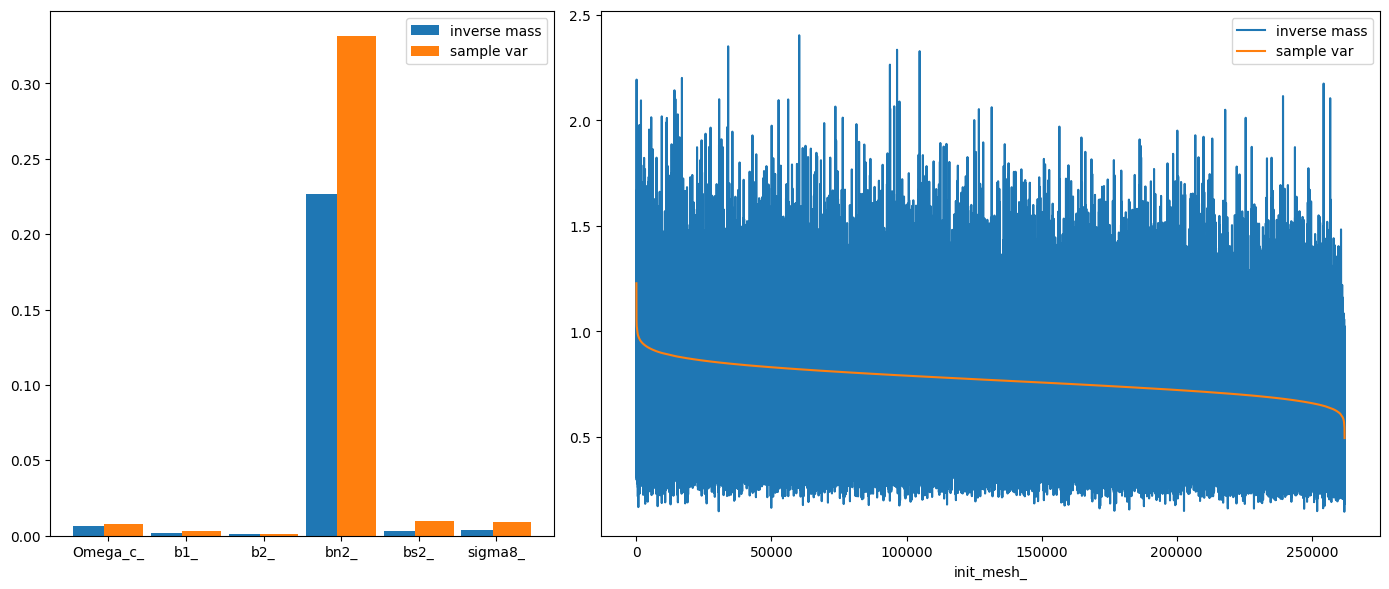

In [143]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    if var_name == 'bnl_':
        var_name = 'bn2_'
    if var_name == 'bs_':
        var_name = 'bs2_'
    var_variance = post_samples_[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,6))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_")
plt.legend(), plt.tight_layout()
plt.savefig(save_path+"_invMvar.svg");

In [ ]:
# # Save posterior variance as inverse mass matrix format
# post_variance = []
# for var_name in var_names:
#     if var_name == 'init_mesh_base':
#         var_name = 'init_mesh'
#         post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
#     else:
#         post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
#         post_variance = np.concatenate((post_variance, ))
# variance_as_invM = {var_names: post_variance}
# print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

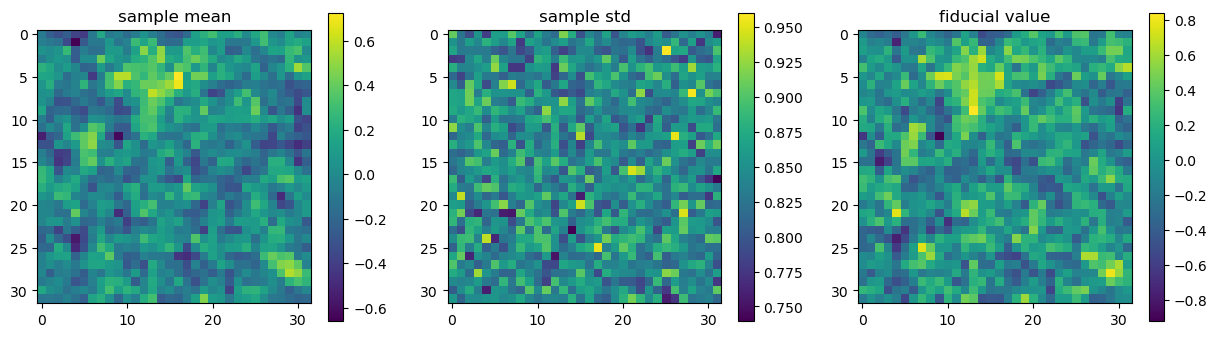

In [ ]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();